In [346]:
import sys
sys.path.append("../Simulations/")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser

from units import *
from spec_calc import PowerSpectra

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [348]:
pspec = PowerSpectra()

# Single subhalo

In [349]:
l_min = 1
l_max = 500
n_l = 50
l_ary = np.logspace(np.log10(l_min), np.log10(l_max), n_l)

In [350]:
M0 = 10**8*M_s
R0 = R0_VL(M0)
Dl = 10*kpc
v = 1e-3

In [354]:
pspec.precompute_NFW = True

In [356]:
Cl_NFW_ary = np.array([pspec.Cl_NFW(M0, Dl, v, l) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_tNFW_ary = np.array([pspec.Cl_tNFW(M0, Dl, v, l, tau=15) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_tNFW2_ary = np.array([pspec.Cl_tNFW(M0, Dl, v, l, tau=10) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_Burk_ary = np.array([pspec.Cl_Burk(M0, Dl, v, l) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2

In [357]:
Cl_Plummer_ary = Cl_Plummer(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Gauss_ary = Cl_Gauss(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Point_ary = Cl_Point(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


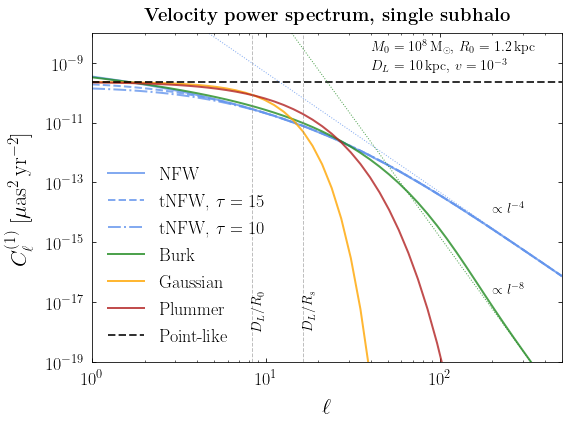

In [360]:
plt.figure(figsize=(8,6))
plt.plot(l_ary, Cl_NFW_ary, label="NFW", alpha=0.8, c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW_ary, label="tNFW, $\\tau = 15$", alpha=0.8, ls='--', c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW2_ary, label="tNFW, $\\tau = 10$", alpha=0.8, ls='-.', c='cornflowerblue')
plt.plot(l_ary, Cl_Burk_ary, label="Burk", alpha=0.8,c='forestgreen')
plt.plot(l_ary, Cl_Gauss_ary, label="Gaussian", alpha=0.8, c='orange')
plt.plot(l_ary, Cl_Plummer_ary, label="Plummer", alpha=0.8, color='firebrick')
plt.plot(l_ary, len(l_ary)*[Cl_Point_ary], label="Point-like", c='k', ls='--', alpha=0.8)

plt.axvline((1/(R0/Dl)), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(R0/Dl)),1e-17,'$D_L/R_0$',rotation=90, fontsize=14)

plt.axvline(1/(pspec.get_rs_rhos_NFW(M0)[0]/Dl), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(pspec.get_rs_rhos_NFW(M0)[0]/Dl)),1e-17,'$D_L/R_s$',rotation=90, fontsize=14)

n = 4
plt.plot(l_ary, (1/l_ary**n)*Cl_NFW_ary[-1]/(1/(l_ary**n)[-1]), lw=1, alpha=0.8, ls='dotted', c='cornflowerblue')

n = 8
l_base = 2000
fac = pspec.Cl_Burk(M0, Dl, v, l_base)/(1e-6*asctorad/Year)**2/(1/(l_base**n))
plt.plot(l_ary, (1/l_ary**n)*fac, lw=1, alpha=0.8, ls='dotted',c='forestgreen')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell^{(1)}$ [$\mu$as$^2$\,yr$^{-2}$]")


plt.xlim(l_min, l_max)
plt.ylim(1e-19,1e-8)

plt.title('\\textbf{Velocity power spectrum, single subhalo}', fontsize=18.5, y=1.02)
plt.text(40, 2.3e-9,'$M_0 = 10^8\,$M$_\odot$, $R_0$ = ' + str(R0/kpc)[:3] + '\,kpc', fontsize=14)
plt.text(40, 5e-10,'$D_L$ = 10\,kpc, $v=10^{-3}$', fontsize=14)

plt.text(200, 1e-14,'$\propto l^{-4}$', fontsize=14)
plt.text(200, 2e-17,'$\propto l^{-8}$', fontsize=14)

plt.legend(frameon=False)

plt.tight_layout()
# plt.savefig("single_sub.pdf")

# Populations

### Set some parameters

In [520]:
Rsun = 8*kpc
Rmin = 1*kpc
Rmax = 200*kpc
M_min = 1e5*M_s
M_max = 1e11*M_s

In [521]:
v0 = 220.*Kmps
vesc = 544.*Kmps
vsun = (11.*Kmps, 12.*Kmps + v0, 7.*Kmps)

Nesc = erf(vesc/v0) - 2/np.sqrt(np.pi)*vesc/v0*np.exp(-vesc**2/v0**2)

In [522]:
DM_frac = 0.5

### Define some distributions

In [523]:
def rho_nfw(r):
    """Unnormalized NFW profile density"""
    r_s = 18*kpc
    return r**2*1/((r/r_s)*(1+r/r_s)**2)

def rho_ein_EAQ(r):
    """ Einasto density profile
    """ 
    r_s = 199.*kpc
    alpha_E = 0.678
    return 4*np.pi*r**2*np.exp(-2/alpha_E*((r/r_s)**alpha_E-1)) 

def rho_v(v):
    """Unnormalized SHM Maxwellian"""
    v0 = 220*Kmps
    if v > 550*Kmps: return 0
    return np.exp(-v**2/v0**2)

def rho_m(ms, mWDM=500*KeV):
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    pref = (1 + mhm(mWDM)/ms)**-1.3
    return pref*dNcdmdm

def mhm(m):
    return 1e10*(m/KeV)**-3.33*M_s/h

def rho_m_cdm(ms):
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    return dNcdmdm

def rho_v(vvec):
    """ Truncated Maxwellian velocity distribution
    """
    v = np.linalg.norm(vvec)
    return 1/(Nesc*np.pi**1.5*v0**3)*np.exp(-v**2/v0**2)*(v < vesc)

def vproj(v, theta, phi, thetap, phip):
    """ Projected velocity in a given direction
    """
    v_vec = v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta_hat = np.array([np.cos(thetap)*np.cos(phip), np.cos(thetap)*np.sin(phip), -np.sin(thetap)])
    phi_hat = [-np.sin(phip), np.cos(phip), 0]
    return np.sqrt(np.dot(v_vec,theta_hat)**2 + np.dot(v_vec,phi_hat)**2)

def R0_VL(M0):
    """ "Concentration-mass" relation for Plummer profile from 1711.03554
    """
    return 1.2*kpc*(M0/(1e8*M_s))**0.5

### Some normalization factors

In [524]:
norm_rho_nfw = nquad(lambda l, theta: rho_ein_EAQ(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]])[0]

In [525]:
norm_rho_m = quad(lambda m: rho_m(m), M_min, M_max)[0]
m_avg = quad(lambda m: m*rho_m(m), M_min, M_max)[0]/norm_rho_m
N_halos = DM_frac*1/(m_avg/(1e12*M_s))

In [526]:
thetap, phip = np.pi/2., np.pi/2.
v_term, _ = nquad(lambda v, theta, phi: v**2*(vproj(v, theta, phi, thetap, phip))**2*np.sin(theta)*rho_v(v),
      [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])
v_term_accel, _ = nquad(lambda v, theta, phi: v**2*(vproj(v, theta, phi, thetap, phip))**4*np.sin(theta)*rho_v(v),
      [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])

### Calculate population integral

In [527]:
l_min = 1
l_max = 2000
n_l = 50

l_ary = np.arange(l_min,l_max)
l_ary_calc = np.logspace(np.log10(l_min), np.log10(l_max), n_l)

In [528]:
def f(x, ell, mWDM=500*KeV, accel=False):
    
    logl, theta, logm = x[0], x[1], x[2]
    m = np.exp(logm)*M_s
    l = np.exp(logl)*kpc
    
    if accel:
        pref = (3/64)*ell**2/l**2
        units = (1e-6*asctorad/Year**2)**2
    else:
        pref = 1
        units = (1e-6*asctorad/Year)**2
        
#     return pref*l*m*Cl_Plummer(R0_VL(m), m, l, 1, ell) / units  * rho_m(m, mWDM=mWDM) * rho_ein_EAQ(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta)))
    return pref*l*m*pspec.Cl_NFW(m, l, 1, ell) / units  * rho_m(m, mWDM=mWDM) * rho_ein_EAQ(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta)))

def get_integral(ell, mWDM=500*KeV, accel=False):
    
    logR_integ_ary = np.linspace(np.log(Rmin/kpc), np.log(Rmax/kpc), 20)
    theta_integ_ary = np.linspace(0, 2*np.pi, 20)
    logM_integ_ary = np.linspace(np.log(M_min/M_s), np.log(M_max/M_s), 20)

    measure = (logR_integ_ary[1] - logR_integ_ary[0])*(theta_integ_ary[1] - theta_integ_ary[0])*(logM_integ_ary[1] - logM_integ_ary[0])
    integ = 0
    for logl in logR_integ_ary:
        for theta in theta_integ_ary:
            for logM in logM_integ_ary:
                integ += f([logl, theta, logM], ell, mWDM, accel)
    integ *= measure
    return integ

# # Checks
# ell = 2
# get_integral(ell)
# mcmiser(lambda x: f(x, ell), npoints=1e5, xl=[np.log(Rmin/kpc),0,np.log(M_min/M_s)], xu=[np.log(Rmax/kpc),2*np.pi,np.log(M_max/M_s)], nprocs=5)

In [529]:
# dmWDM = 0.1*KeV
mWDM = 2000*KeV

conv_fid = [get_integral(ell, mWDM=mWDM) for ell in tqdm_notebook(l_ary_calc)]
# conv_p = [get_integral(ell, mWDM=(3.3*KeV + dmWDM)) for ell in tqdm_notebook(l_ary_calc)]
# conv_m = [get_integral(ell, mWDM=(3.3*KeV - dmWDM)) for ell in tqdm_notebook(l_ary_calc)]

In [500]:
conv_fid_accel = [get_integral(ell, mWDM=mWDM, accel=True) for ell in tqdm_notebook(l_ary_calc)]
# conv_p_accel = [get_integral(ell, mWDM=(3.3*KeV + dmWDM), accel=True) for ell in tqdm_notebook(l_ary_calc)]
# conv_m_accel = [get_integral(ell, mWDM=(3.3*KeV - dmWDM), accel=True) for ell in tqdm_notebook(l_ary_calc)]

In [530]:
C_l_fid = N_halos*np.array(conv_fid) * v_term / norm_rho_m / norm_rho_nfw
C_l_fid_interp = 10**np.interp(np.log10(l_ary), np.log10(l_ary_calc), np.log10(C_l_fid))

In [531]:
# C_l_p = N_halos*np.array(conv_p) * v_term / norm_rho_m / norm_rho_nfw
# C_l_p_interp = 10**np.interp(np.log10(l_ary), np.log10(l_ary_calc), np.log10(C_l_p))

# C_l_m = N_halos*np.array(conv_m) * v_term / norm_rho_m / norm_rho_nfw
# C_l_m_interp = 10**np.interp(np.log10(l_ary), np.log10(l_ary_calc), np.log10(C_l_m))

In [532]:
C_l_fid_accel = N_halos*np.array(conv_fid_accel) * v_term_accel / norm_rho_m / norm_rho_nfw
C_l_fid_accel_interp = 10**np.interp(np.log10(l_ary), np.log10(l_ary_calc), np.log10(C_l_fid_accel))

In [533]:
# C_l_p_accel = N_halos*np.array(conv_p_accel) * v_term / norm_rho_m / norm_rho_nfw
# C_l_p_interp_accel = 10**np.interp(np.log10(l_ary), np.log10(l_ary_calc), np.log10(C_l_p_accel))

# C_l_m_accel = N_halos*np.array(conv_m_accel) * v_term / norm_rho_m / norm_rho_nfw
# C_l_m_interp_accel = 10**np.interp(np.log10(l_ary), np.log10(l_ary_calc), np.log10(C_l_m_accel))

In [534]:
sigma_mu = 1
sigma_alpha = .1
N_q = 1e9

(1e-19, 1e-05)

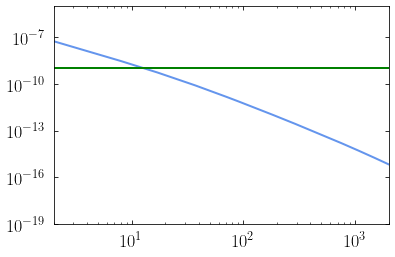

In [535]:
plt.plot(l_ary, C_l_fid_interp)
plt.axhline(sigma_mu**2/N_q, color='green')

plt.yscale("log")
plt.xscale("log")
plt.xlim(2, 2000)
plt.ylim(1e-19,1e-5)

(2, 2000)

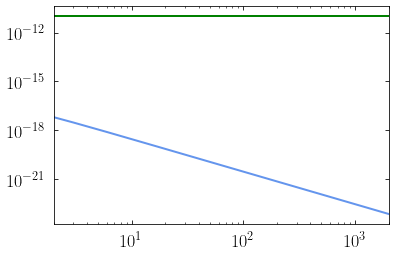

In [542]:
plt.plot(l_ary, C_l_fid_accel_interp)
plt.axhline(sigma_alpha**2/N_q, color='green')

plt.yscale("log")
plt.xscale("log")
plt.xlim(2, 2000)
# plt.ylim(1e-19,1e-5)

## Fisher analysis

In [537]:
from astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

In [538]:
tau_int = 10. # Years
sigma_mu = 1. # muas/Year
N_q = 1e9

In [541]:
fDM = Parameter('fDM', 0.5 ,0.02 , True, C_l_fid_interp*(1 + 0.02), C_l_fid_interp*(1 - 0.02), 
                C_l_fid_accel_interp*(1 + 0.02), C_l_fid_accel_interp*(1 - 0.02), '$\\f_\mathrm{DM}$' )

mWDM = Parameter('mwDM', 3.3*KeV ,dmWDM , False, C_l_p_interp, C_l_m_interp, 
                C_l_p_interp_accel, C_l_m_interp_accel, '$\\m_\mathrm{WDM}$' )

parameters = [C_l_fid_interp, C_l_fid_accel_interp, 1, 2000, fDM, mWDM]
observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=sigma_mu/tau_int**2, N_q=N_q, l_min_mu=10, l_max_mu=2000, l_min_alpha=10, l_max_alpha=2000)

fshr = FisherForecast(parameters, observation)

0.1502354246223551


In [339]:
# fshr.plot_fisher([fshr.fshr_cls], fc=["None"], lw=[1], lc=['forestgreen'])

## wDM misc